In [33]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import uvicorn



In [26]:
file_path = "/content/emails.csv"
df = pd.read_csv(file_path)

# Check for missing values
df.dropna(inplace=True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['spam'], test_size=0.2, random_state=42)



In [27]:
print(df)

                                                   text  spam
0     Subject: naturally irresistible your corporate...     1
1     Subject: the stock trading gunslinger  fanny i...     1
2     Subject: unbelievable new homes made easy  im ...     1
3     Subject: 4 color printing special  request add...     1
4     Subject: do not have money , get software cds ...     1
...                                                 ...   ...
5723  Subject: re : research and development charges...     0
5724  Subject: re : receipts from visit  jim ,  than...     0
5725  Subject: re : enron case study update  wow ! a...     0
5726  Subject: re : interest  david ,  please , call...     0
5727  Subject: news : aurora 5 . 2 update  aurora ve...     0

[5728 rows x 2 columns]


In [28]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [29]:
# Define individual classifiers
rf = RandomForestClassifier(n_estimators=100, random_state=42)
nb = MultinomialNB()
svm = SVC(kernel='linear', probability=True, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [30]:
# Create an ensemble model using Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[('Random Forest', rf), ('Naïve Bayes', nb), ('SVM', svm), ('Gradient Boosting', gb)],
    voting='hard'  # Use 'soft' for probability-based voting
)

In [31]:
# Train the ensemble model
print("Training ensemble model...")
ensemble_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = ensemble_model.predict(X_test_tfidf)

Training ensemble model...


In [34]:
# Save the trained model
model_path = "spam_classifier.pkl"
with open(model_path, "wb") as model_file:
    pickle.dump((vectorizer, ensemble_model), model_file)

In [35]:
# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Ensemble Model Accuracy: 0.9808
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       856
           1       1.00      0.92      0.96       290

    accuracy                           0.98      1146
   macro avg       0.99      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146



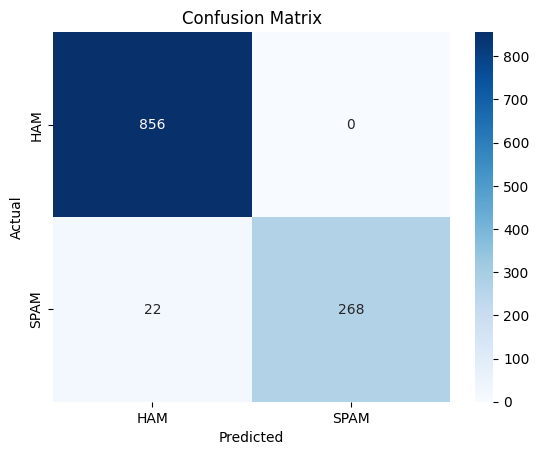

In [36]:
# Visualization of accuracy and confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['HAM', 'SPAM'], yticklabels=['HAM', 'SPAM'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [37]:
# Load the trained model before checking individual email content
with open(model_path, "rb") as model_file:
    vectorizer, loaded_model = pickle.load(model_file)

In [38]:
# User input for email content classification
print("\nEnter email content to classify. Press Enter twice to submit:")
email_content = []
while True:
    line = input()
    if line == "":  # Stop input on empty line
        break
    email_content.append(line)
user_email_text = " ".join(email_content)

# Transform input and predict
user_email_tfidf = vectorizer.transform([user_email_text])
prediction = loaded_model.predict(user_email_tfidf)

if prediction[0] == 1:
    print("The email content is classified as SPAM.")
else:
    print("The email content is classified as HAM (not spam).")


Enter email content to classify. Press Enter twice to submit:
u won lot of free prizes

The email content is classified as HAM (not spam).


In [ ]:
# FastAPI setup
app = FastAPI(title="Spam Email Classifier API")

# Load model
with open(model_path, "rb") as model_file:
    vectorizer, loaded_model = pickle.load(model_file)

# Request model
class EmailInput(BaseModel):
    text: str

# API endpoint for email classification
@app.post("/predict")
def predict_email(email: EmailInput):
    email_tfidf = vectorizer.transform([email.text])
    prediction = loaded_model.predict(email_tfidf)
    result = "SPAM" if prediction[0] == 1 else "HAM"
    return {"prediction": result}

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=8000)